# 导入必须的模块

In [1]:
# 导入模块
import os
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

# 高级参数配置，一般不需要更改

In [29]:
def get_args_parser():

    custom_param = config()

    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=custom_param.lr, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=custom_param.batch_size, type=int)
    parser.add_argument('--weight_decay', default=custom_param.weight_decay, type=float)
    parser.add_argument('--epochs', default=custom_param.epochs, type=int)
    parser.add_argument('--lr_drop', default=custom_param.lr_drop, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--num_classes', default=custom_param.num_classes, type=int,
                        help='#classes in your dataset, which can override the value hard-coded in file models/detr.py')
    parser.add_argument('--dataset_file', default=custom_param.dataset_file)
    parser.add_argument('--coco_path', default=custom_param.coco_path, type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default=custom_param.output_dir,
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default=custom_param.device,
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=custom_param.seed, type=int)
    parser.add_argument('--resume', default=custom_param.resume, help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=custom_param.num_workers, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=3, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser

#  基本参数配置，主要配置这个就行

In [41]:
class config:
    lr = 1e-4 # 学习率
    lr_backbone = 1e-5 # backbone的学习率
    lr_drop = 50
    batch_size = 1
    weight_decay = 1e-4
    epochs = 100

    # dataset parameters
    num_classes = 5 # 类别数

    dataset_file = "custom" # 使用自定义的数据库函数，不需要更改

    coco_path = r"MyDatasets" # 自定义数据集路径的路径

    # device = 'cuda' if torch.cuda.is_available() else "cpu" # device to use for training / testing
    device = "cpu"
    seed = 42 # 随机种子

    resume = "detr-r50_no-class-head.pth" # 'resume from checkpoint'

    num_workers = 2 # 读取数据的进程数

    output_dir = "outputs" # 保存模型的路径

# 准备工作

In [42]:
# 获取配置参数
# parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args = get_args_parser().parse_args([])
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

In [43]:
# 初始化分布式模型参数配置
utils.init_distributed_mode(args)

# 打印参数配置信息
print(args)

device = torch.device(args.device)

# 固定随机种子以便于复现
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Not using distributed mode
Namespace(aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='D:\\dataset\\MyDatasets', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=100, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=50, mask_loss_coef=1, masks=False, nheads=8, num_classes=5, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=3)


# 评估阶段

In [51]:
!pip install seaborn
# 导入模块
from util.plot_utils import plot_logs
from pathlib import Path
import torch
from matplotlib import pyplot as plt
from PIL import Image
import torchvision.transforms as T
import time
import datetime

In [52]:
# 读取分类标签
with open("mask_outdoor_classes.txt", "r")as f:
    finetuned_classes = f.read().split("\n")
# 类别数
num_classes = len(finetuned_classes)

# 对输入的图片进行resize和标准化
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 定义框的颜色
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

img_name = ""

# 读取模型网络
model, _, _ = build_model(args)
# 也可以从GitHub上读取模型网络
#     model = torch.hub.load('facebookresearch/detr',
#                            'detr_resnet50',
#                            pretrained=False,
#                            num_classes=num_classes)

# 读取自己训练好的模型权重
checkpoint = torch.load('outputs/outdoor_0625.pth',
                            map_location='cpu')

model.load_state_dict(checkpoint['model'],
                          strict=False)

model.eval()

In [53]:
# 将模型输出的box的表示由xmid,ymid,width,height 转化为 xmin,ymin,xmax,ymax方便画图
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


In [54]:
# 根据图片尺寸对框进行等比例变化以适应
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [55]:
# 根据阈值对输出的框进行过滤
def filter_bboxes_from_outputs(outputs,
                               threshold, im):
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled

In [56]:
# 将框，分类，score等信息绘制到图片上并显示和保存
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    global img_name
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    plt.savefig(img_name.split("/")[-1].replace(".jpg","")+"_result.jpg")

In [57]:
# 用模型对图片进行预测，并绘制框，类别等信息
def run_worflow(my_image, my_model):
    # 对图片进行处理以便与输入到模型
    img = transform(my_image).unsqueeze(0)
    start_time = time.time()
    # 使用模型进行预测
    outputs = my_model(img)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(total_time_str)
    # 设定阈值对框进行过滤
    for threshold in [0.6]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                                   threshold=threshold,im=my_image)
        # 将符合条件的框绘制到图片上
        plot_finetuned_results(my_image,probas_to_keep,bboxes_scaled)

In [58]:
# 获取训练的log
def get_log_figure():
    # 将训练过程的loss，map变化曲线进行绘制
    log_directory = [Path('outputs/')]

    fields_of_interest = (
        'loss',
        'mAP',
    )
    plot_logs(log_directory,
              fields_of_interest)

    # 将ce，bbox，giou等loss变化曲线进行绘制
    fields_of_interest = (
        'loss_ce',
        'loss_bbox',
        'loss_giou',
    )
    plot_logs(log_directory,
              fields_of_interest)

    # 对训练过程中的分类错误率变化进行绘制
    fields_of_interest = (
        'class_error',
        'cardinality_error_unscaled',
    )

    plot_logs(log_directory,
              fields_of_interest)

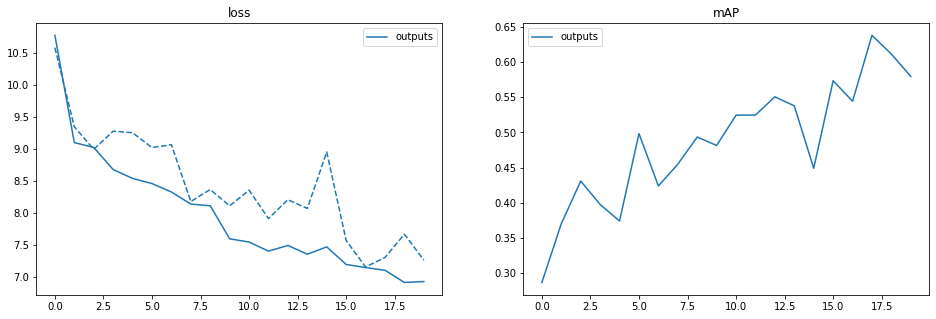

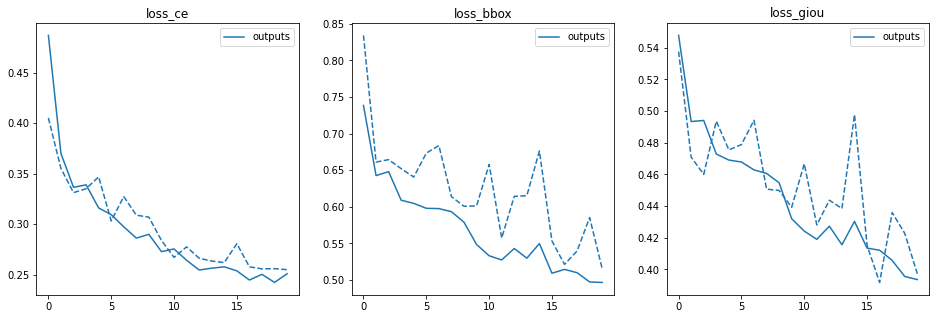

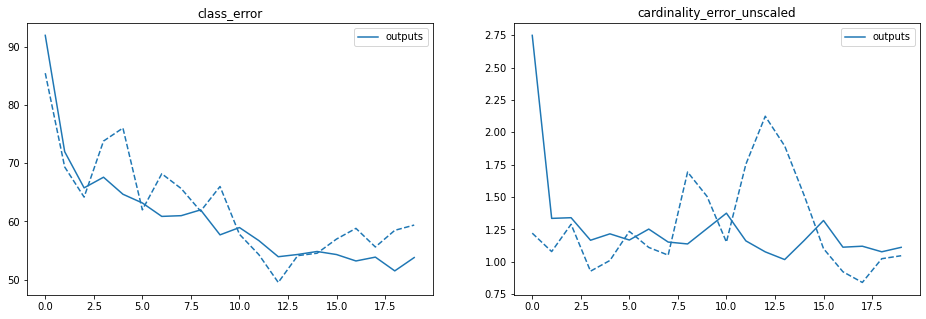

In [16]:
get_log_figure() #获取log并保存到本地

In [61]:
# 读入图片检查效果
def img_predict(img_pth):
    global img_name

    # 读取图片进行预测
    img_name = img_pth
    im = Image.open(img_name)
    run_worflow(im, model)

0:00:02


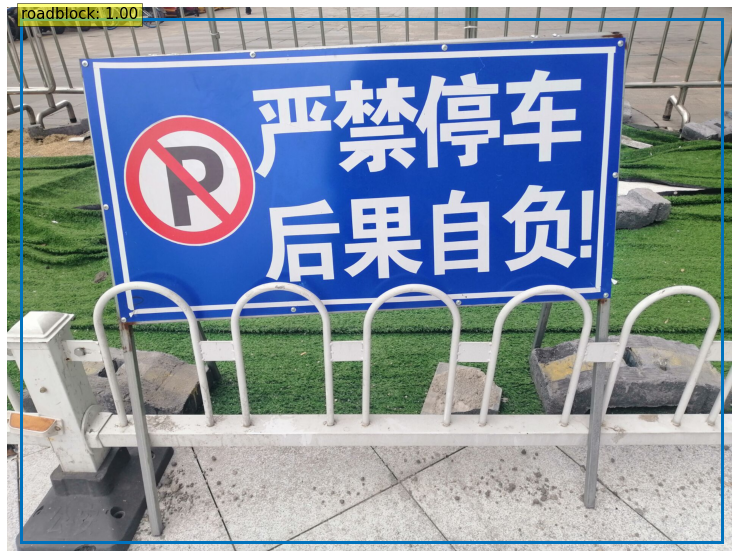

<Figure size 432x288 with 0 Axes>

In [62]:
img_predict(img_pth=r'LZ63.jpg')
img_predict(img_pth=r'LT15.jpg')